# Quantifying Uncertainty: Bayesian Data Analysis in Python

Here I'm building code and figures for my talk on Bayesian data analysis.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd

import sampyl as smp
from sampyl import np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.size'] = 16.
plt.rcParams['legend.fontsize'] = 16.0
plt.rcParams['axes.titlesize'] = 18.0
plt.rcParams['axes.labelsize'] = 16.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0

What's the entire story? Let me lock this down first.

Whenever we're working with data, there is necessarily uncertainty in our results. Firstly, we can't collect all the possible data, so instead we sample from a population. There is also uncertainty from missing data, systematic errors in the experiment or data collection, and many more sources of error, although most studies are designed to minimize these types of errors. We must understand and quantify this uncertainty so we can judge the quality of our final results. If there is low uncertainty in our results, we can be confident in our analysis. On the other hand, if the uncertainty is high, we should be wary.

As a test of our results in the face of uncertainty, traditionally we'd turn to hypothesis testing. For a classic example, in clinic drug trials, you want to compare a group of people given a drug vs a group of people given a placebo. We're looking to see if the drug produces a substantial change in some metric (cholesterol levels for example) compared to the placebo. However, any difference we see might be 

Typically you'd use hypothesis testing and calculate things like t-statistics and eventually a p-value. However, hypothesis testing and p-values are in general a poor way of quantifying uncertainty. Firstly, p-values have sampling distributions, which means there is uncertainty in the p-value itself. With a medium effect and roughly 100 people in a trial, you're about 70% likely to get p < 0.05 from any one experiment. From one experiment, with a typical effect size and a typical sample size, it's   This leads to p-values being uninformative unless you have a lot of data, but if you have a lot of data you don't really need to perform statistical tests (you can just visually inspect the data).

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
effect = 0.3
N = 100 # Number of samples per experiment
M = 10000 # Number of experiments

control = np.random.randn(M, N)
treatment = np.random.randn(M, N) + effect
null = np.random.randn(M, N)

fig, axs = plt.subplots(figsize=(4,7), nrows=3, sharex=True, sharey=True)
for ax, sample in zip(axs, control):
    ax.hist(sample, bins=30)

In [ ]:
plt.hist(control[3], alpha=0.5, bins=20, label='Control')
plt.hist(treatment[3], alpha=0.5, bins=20, label='Treatment')
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
plt.legend()

In [ ]:
tstats_null, pvals_null = ttest_ind(control, null, axis=1)
tstats, pvals = ttest_ind(control, treatment, axis=1)

In [ ]:
idx = 3
plt.hist(tstats_null, bins=50, density=True)
plt.vlines(np.abs(tstats[idx]), 0, 0.4, linestyle='--', color='#888888')
plt.xlabel('t-statistic')
pval = np.mean(tstats_null > np.abs(tstats[idx]))
plt.text(np.abs(tstats[idx])+0.2, 0.30, 
         f"t = {np.abs(tstats[idx]):.3f}\np = {pvals[idx]:.3f}",
         size='large')
print(pval*2, pvals[idx])

In [ ]:
tstats, pvals = ttest_ind(control, treatment, axis=1)
plt.hist(pvals, bins=30, range=(0, 0.2), density=True)
plt.xlim(0, 0.2)
plt.xlabel('p-value')
plt.ylabel('Probability')
p_sig = np.mean(pvals < 0.05)
plt.text(0.053, 35, r"$P(p < 0.05) = {:.3f}$".format(p_sig), size='large')
plt.vlines(0.05, 0, 55, linestyle='--', alpha=0.7)
plt.title("Sampling distribution for p")

In [ ]:
plt.hist(tstats)

In [ ]:
p_sigs = {0.2: [], 0.5: [], 0.8: []}
sizes = np.linspace(0, 200)
for effect in p_sigs.keys():
    for samp_size in sizes:
        control = np.random.randn(1000, int(samp_size))
        treatment = np.random.randn(1000, int(samp_size)) + effect

        pvals = ttest_ind(control, treatment, axis=1)[1]
        p_sigs[effect].append(np.median(pvals))

In [ ]:
for each in p_sigs:
    plt.plot(sizes, p_sigs[each], label=f'd = {each}')
plt.xlabel('Sample size')
plt.ylabel('Median of P(p)')
plt.legend(fontsize='large')

Over the last decade or so, hypothesis testing has been heavily criticized for these reasons (and many more issues). In response, there has been a shift to parameter estimation using confidence intervals. However, again, confidence intervals don't answer the questions we are asking. Many people interpret a 95% confidence interval as there is a 95% probability that the true parameter falls within that interval. However, the correct interpretation is if you performed your experiment an infinite number of times and calculated the confidence interval for each of those experiments, then 95% of the time, the true parameter would fall within the interval.

Hypothesis testing and confidence intervals are examples of 

In [ ]:
effect = 0.3
control = np.random.randn(1000, 100)
treatment = np.random.randn(1000, 100) + effect

plt.hist(control[0], alpha=0.5, bins=20, label='Control')
plt.hist(treatment[0], alpha=0.5, bins=20, label='Treatment');

In [266]:
def make_experiment(effect=0.3, n_samples=50):

    effect = 0.3
    rand_effect = np.random.rand()*0.25
    control = np.random.randn(n_samples) + rand_effect
    treatment = np.random.randn(n_samples) + rand_effect + effect

    def logp(μ_1, σ_1, μ_2, σ_2):

        model = smp.Model()

        # Priors for means
        model.add(smp.uniform(μ_1, -10, 10),
                  smp.uniform(μ_2, -10, 10))

        # Priors for standard devs
        model.add(smp.half_cauchy(σ_1, beta=5),
                  smp.half_cauchy(σ_2, beta=5))

        # Data Likelihood
        model.add(smp.normal(control, mu=μ_1, sig=σ_1),
                  smp.normal(treatment, mu=μ_2, sig=σ_2))

        return model()
    
    return logp

In [ ]:
posteriors = {}

for N in [10, 100, 1000]:
    logp = make_experiment(n_samples=N)
    start = {'μ_a': 0., 'σ_a': 1., 'μ_b': 0., 'σ_b': 1.}
    sampler = smp.Slice(logp, start)
    chain = sampler(5000, burn=2500, thin=5)
    posteriors[N] = (chain.μ_b - chain.μ_a)

In [ ]:
plt.plot(chain.μ_a);

In [ ]:
diff_posterior = chain.μ_b - chain.μ_a
CR = np.percentile(diff_posterior, (2.5, 97.5))
fig, ax = plt.subplots()
ax.hist(diff_posterior, bins=50, density=True, alpha=0.6, range=(-0.5, 1.5))

ax.hlines(0.04, *CR, lw=7, label=f'95% Credible Region: {{{CR[0]:.3f}, {CR[1]:.3f}}}')
ax.set_title(r'Posterior for $\mu_T - \mu_C$, N = 50')
ax.legend(loc='upper left')
ax.set_ylim(0, 3.5)
ax.set_xlim(-0.5, 1.5)
ax.set_xlabel(r'$\mu_T - \mu_C$')
ax.set_ylabel(r'$P(\mu_T - \mu_C \mid D)$');

In [ ]:
fig, histax = plt.subplots(figsize=(9, 6))
#fig, (histax, errax) = plt.subplots(figsize=(5, 6), nrows=2, sharex=True)
for each in posteriors:
    histax.hist(posteriors[each], range=(-1, 2), bins=40, density=True,
            alpha=0.4, label=f'N = {each}')
#histax.legend()

histax.set_ylabel(r'$P(\mu_T - \mu_C \mid D)$')
histax.set_xlabel(r'$\mu_T - \mu_C$')

# for ii, each in enumerate(posteriors):
#     mean = posteriors[each].mean()
#     CR = np.percentile(posteriors[each], (2.5, 97.5))
    
#     errax.errorbar(mean, ii, xerr=np.abs(CR - mean)[:, None], fmt='o')
# errax.vlines(0.3, -1, 3, linestyle='--', alpha=0.5)
# errax.set_xlabel(r'$\mu_T - \mu_C$')
# errax.set_ylim(-0.5, 2.5)
# errax.set_yticks((0, 1, 2))
# errax.set_yticklabels((posteriors.keys()))
# errax.set_ylabel('Sample size')

In [353]:
logp = make_experiment(n_samples=100)
start = {'μ_1': 0., 'σ_1': 1., 'μ_2': 0., 'σ_2': 1.}
sampler = smp.NUTS(logp, start)
chain = sampler(6100, burn=100, thin=2)

Progress: [##############################] 6100 of 6100 samples


(-0.5, 1.2)

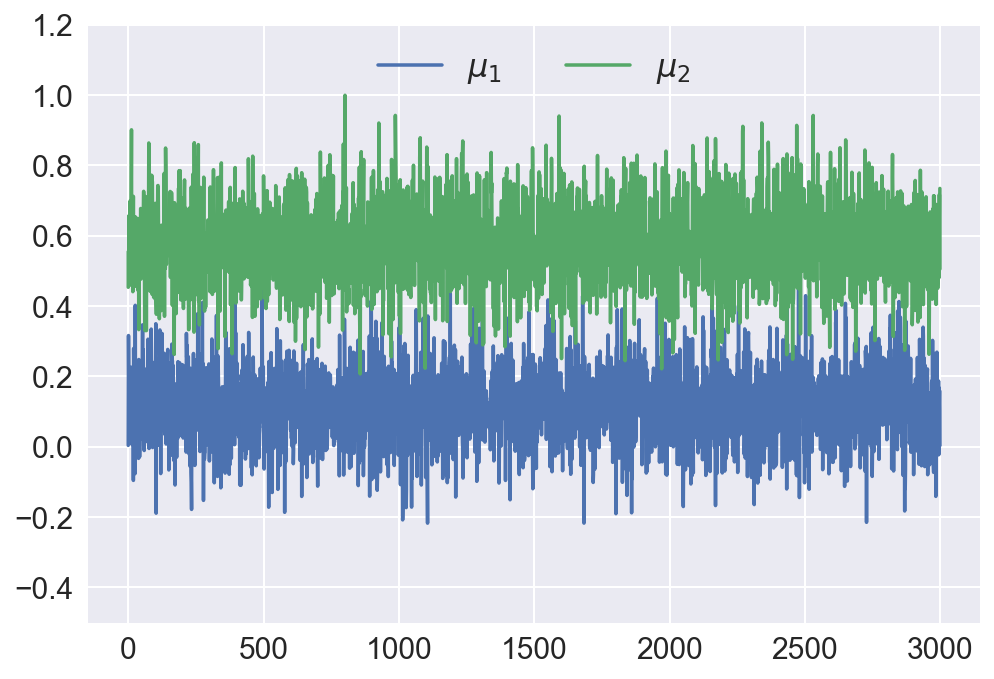

In [371]:
plt.plot(chain.μ_1, label=r'$\mu_1$')
plt.plot(chain.μ_2, label=r'$\mu_2$')
plt.legend(loc='upper center', ncol=2)
plt.ylim(-0.5, 1.2)

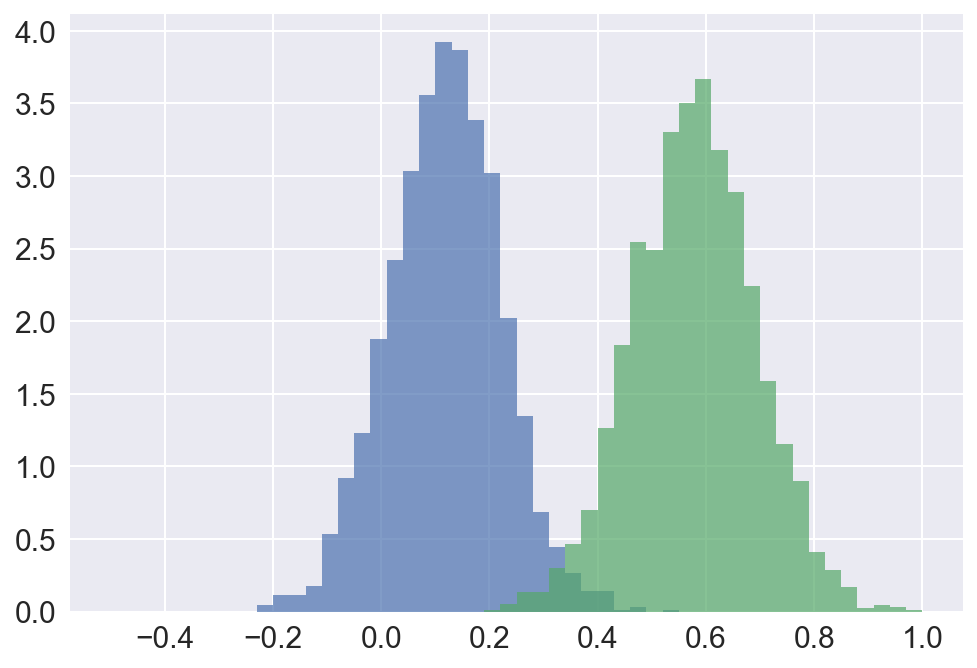

In [372]:
for posterior in [chain.μ_1, chain.μ_2]:
    plt.hist(posterior, bins=50, range=(-0.5, 1), alpha=0.7, density=True);

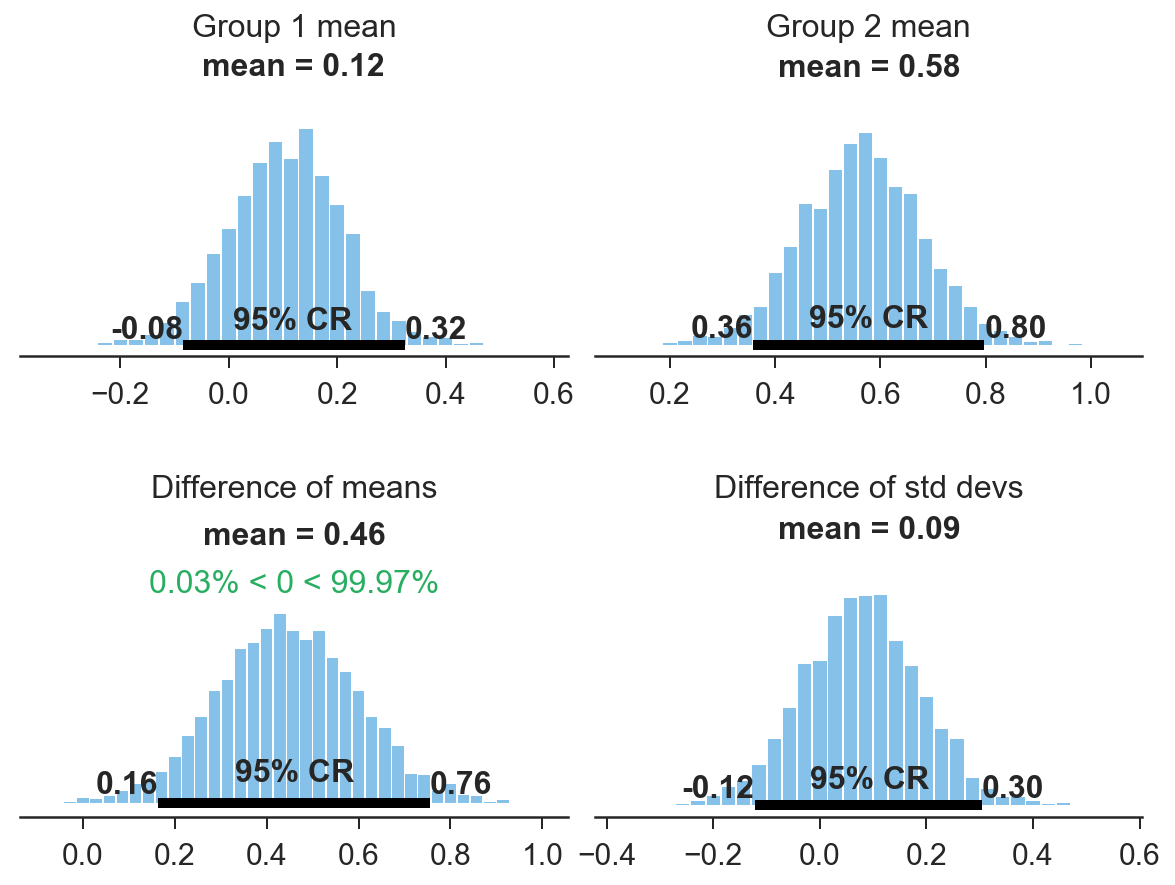

In [373]:
plt.style.use('seaborn-ticks')
fig, axes = plt.subplots(figsize=(8,6), ncols=2, nrows=2)
posteriors = [chain.μ_1, chain.μ_2, chain.μ_2 - chain.μ_1, chain.σ_2 - chain.σ_1]
for ax, posterior in zip(axes.flatten(), posteriors):
    hist, bin_edges = np.histogram(posterior, range=(-1, 1), bins=70, density=True)
    ax.bar(bin_edges[:-1], hist, 0.025, color='#85C1E9')
    mean = np.mean(posterior)
    CR = np.percentile(posterior, (2.5, 97.5))
    ax.hlines(0, CR[0], CR[1], linewidth=5)
    ax.set_ylim(-0.2, max(hist)+1.5)
    ax.set_xlim(left=CR[0]-0.3, right=CR[1]+0.3)
    ax.text(CR[0], 0.13, f"{CR[0]:.2f}", weight='bold', ha='right')
    ax.text(CR[1], 0.13, f"{CR[1]:.2f}", weight='bold')
    ax.text(mean, ax.get_ylim()[1] - 0.5, f"mean = {mean:.2f}", weight='bold', ha='center')
    ax.text(mean, ax.get_ylim()[0] + 0.5, f"95% CR", weight='bold', ha='center')
    ax.set_yticklabels('')
    for each in ['top', 'left', 'right']:
        ax.spines[each].set_visible(False)
    ax.tick_params(top=False, left=False, right=False)

axes[0,0].set_title("Group 1 mean", size=16)
axes[0,1].set_title("Group 2 mean", size=16)
axes[1,0].set_title("Difference of means", size=16)
axes[1,1].set_title("Difference of std devs", size=16)

gt0 = np.mean(posteriors[2] > 0)*100
axes[1,0].text(np.mean(posteriors[2]), axes[1,0].get_ylim()[1] - 1.2, 
             f"{100-gt0:.2f}% < 0 < {gt0:.2f}%",
             ha='center', color='#27AE60')
fig.tight_layout(pad=0.1, w_pad=0.1, h_pad=2)

In [352]:
disaster_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, 0, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, 0, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
year = np.arange(1851, 1962)

In [ ]:
fig, ax = plt.subplots(figsize=(7,3))
plt.bar(year, disaster_data, width=1)
plt.ylabel('Disaster count')
plt.xlabel("Year")

# Predicting coin flips

In [4]:
from scipy import stats

(0, 4.2)

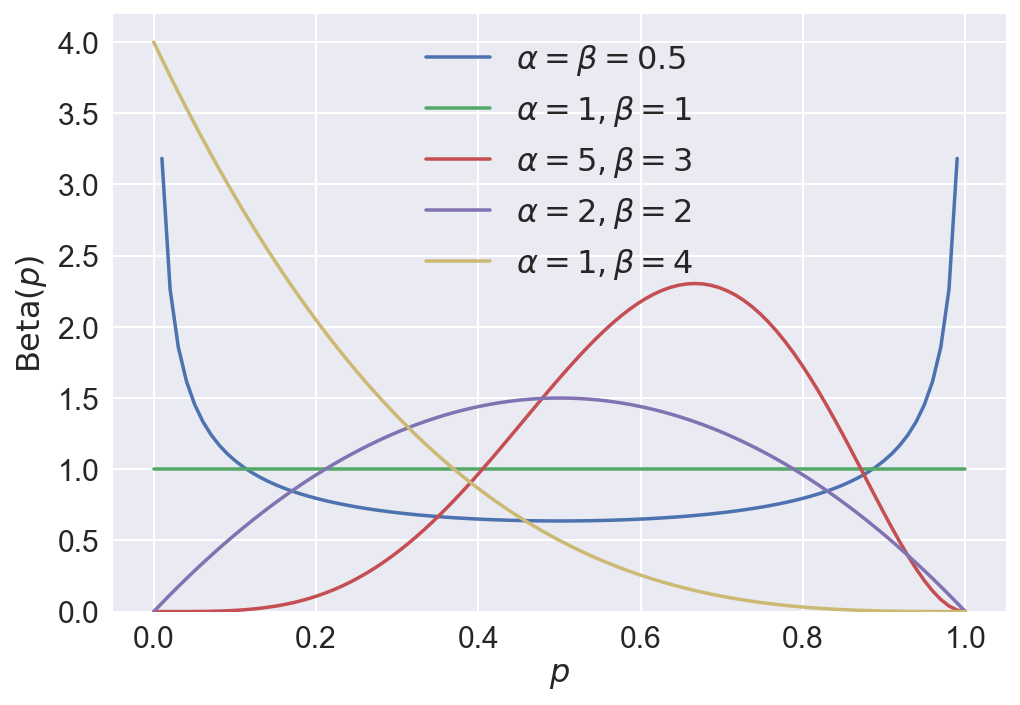

In [66]:
xs = np.linspace(0, 1, num=100)
plt.plot(xs, stats.beta.pdf(xs, 0.5, 0.5), label=r'$\alpha=\beta=0.5$')
plt.plot(xs, stats.beta.pdf(xs, 1, 1), label=r'$\alpha=1, \beta=1$')
plt.plot(xs, stats.beta.pdf(xs, 5, 3), label=r'$\alpha=5, \beta=3$')
plt.plot(xs, stats.beta.pdf(xs, 2, 2), label=r'$\alpha=2, \beta=2$')
plt.plot(xs, stats.beta.pdf(xs, 1, 4), label=r'$\alpha=1, \beta=4$')
plt.legend(loc='upper center')
plt.ylabel(r'$\mathrm{Beta}(p)$')
plt.xlabel(r'$p$')
plt.ylim(0)

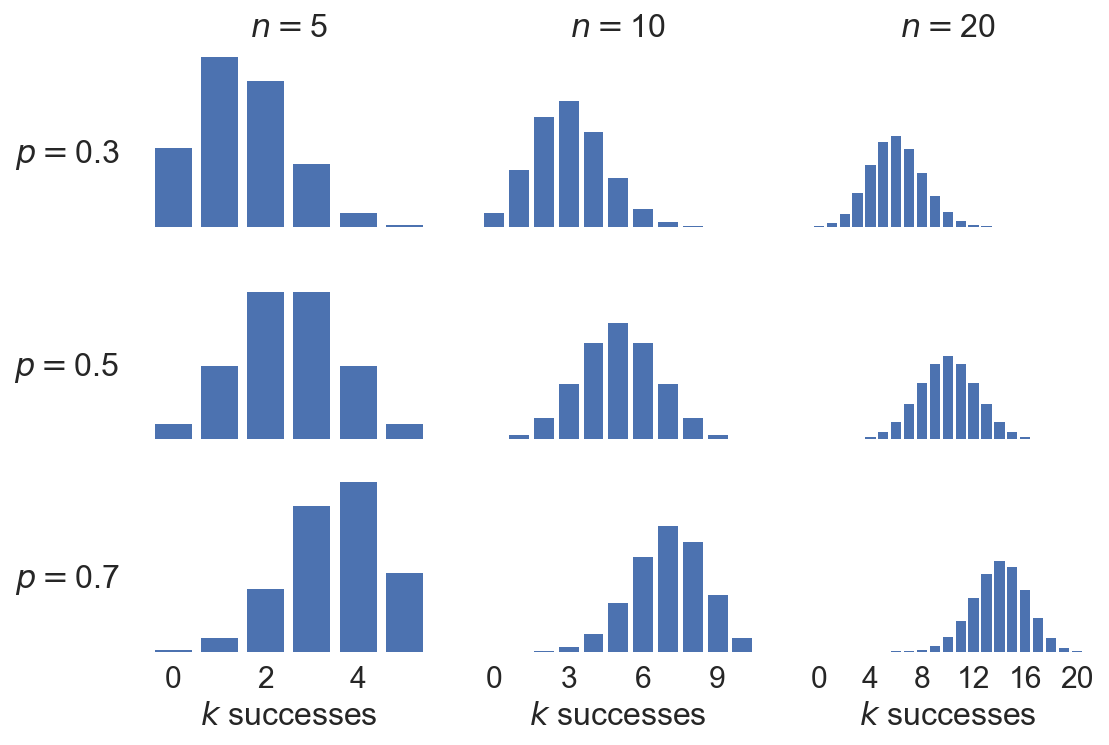

In [58]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True)
for x_ax, p in enumerate([0.3, 0.5, 0.7]):
    for y_ax, n in enumerate([5, 10, 20]):
        ax = axes[x_ax, y_ax]
        ks = np.arange(0,n+1,1)
        ax.bar(ks, stats.binom.pmf(ks, n, p))
        
        ax.set_yticklabels('')
        ax.grid(False)
        ax.set_facecolor('w')
        
        
        if x_ax == 0:
            ax.set_title(r'$n=${}'.format(n), size='medium')
        
        if x_ax == 2:
            ax.set_xticks(ks[::int(np.sqrt(n))])
            ax.set_xticklabels([str(each) for each in ks[::int(np.sqrt(n))]])
            ax.set_xlabel(r'$k$ successes')
        else:
            ax.set_xticklabels('')
            
        if y_ax == 0:
            ax.set_ylabel(r'$p=${}'.format(p), rotation=0, va='top', ha='right')
# ax.set_xlabel(r'$k$ heads')
# ax.set_ylabel(r'$P\left(k \mid n, p\right)$')
fig.tight_layout()

In [72]:
flips

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

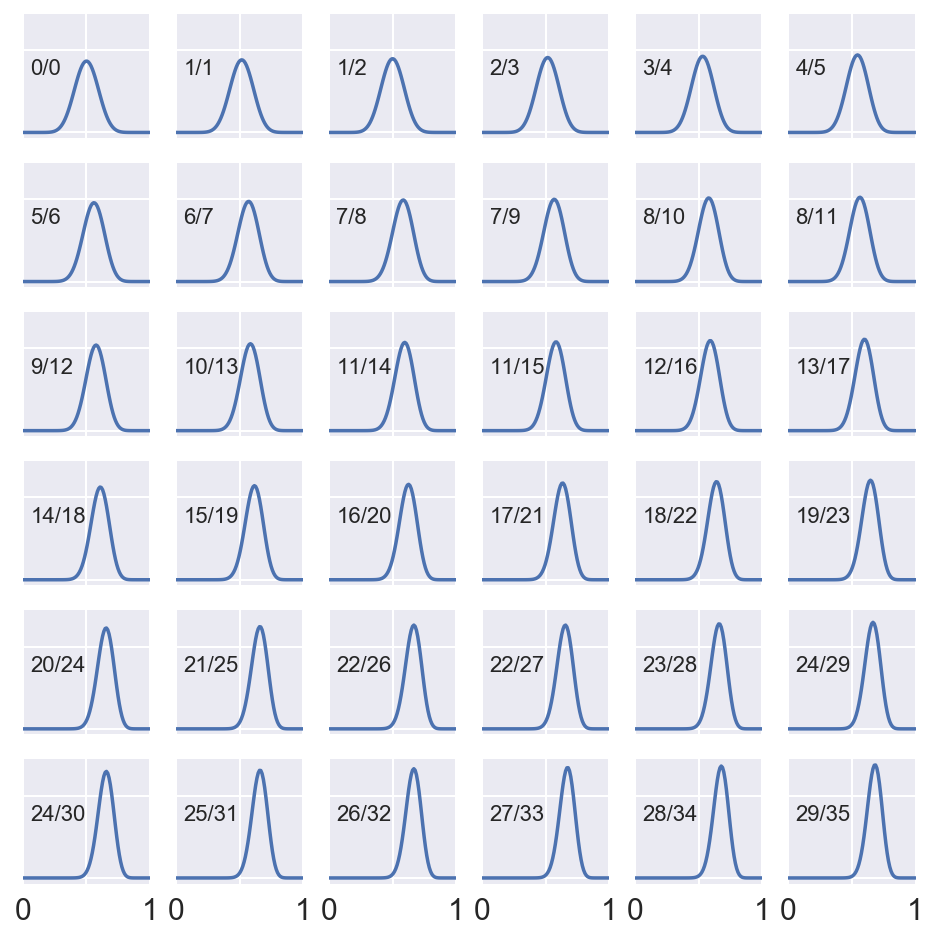

In [122]:
xs = np.linspace(0, 1, num=100)
α, β = 15, 15
flips = stats.bernoulli.rvs(0.7, size=36)
fig, axes = plt.subplots(figsize=(8, 8),
                         ncols=int(np.sqrt(len(flips))),
                         nrows=int(np.sqrt(len(flips))),
                         sharex=True, sharey=True)

for ii, ax in enumerate(axes.flatten()):
    ax.set_xlim(0, 1)
    ax.set_yticklabels('')
    ax.plot(xs, stats.beta.pdf(xs, α + np.sum(flips[:ii]), β + ii - np.sum(flips[:ii])))
    ax.text(0.06, 3.5, f'{np.sum(flips[:ii])}/{ii}', size='x-small')
    ax.grid(True, axis='x', which='minor')
    ax.set_xticks((0, 0.5, 1))
    ax.set_xticklabels(('0', '', '1'))


In [123]:
posterior = stats.beta(α + flips.sum(), β + len(flips) - flips.sum())

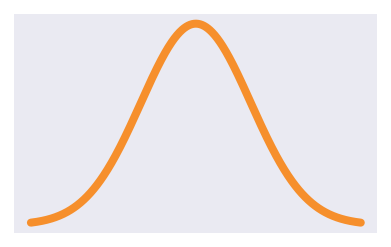

In [157]:
fig, ax = plt.subplots(figsize=(3,2))
xs = np.linspace(-3, 3, 500)
ax.plot(xs, stats.norm.pdf(xs), color='#F68F2C', lw=4)
ax.grid(False)
ax.set_alpha(0)
ax.set_xticklabels('')
ax.set_yticklabels('')
fig.tight_layout()
fig.savefig('/Users/mat/Desktop/normal.png', transparent=True, dpi=300)

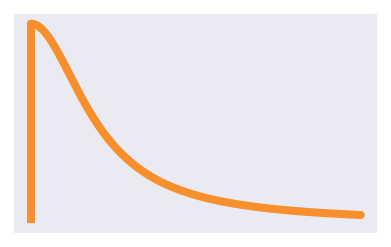

In [160]:
fig, ax = plt.subplots(figsize=(3,2))
xs = np.linspace(0, 5, 500)
ax.plot(xs, stats.cauchy.pdf(xs), color='#F68F2C', lw=4)
ax.vlines(0, 0, stats.cauchy.pdf(0), color='#F68F2C', lw=4)
ax.grid(False)
ax.set_alpha(0)
ax.set_xticklabels('')
ax.set_yticklabels('')
fig.tight_layout()
fig.savefig('/Users/mat/Desktop/cauchy.png', transparent=True, dpi=300)

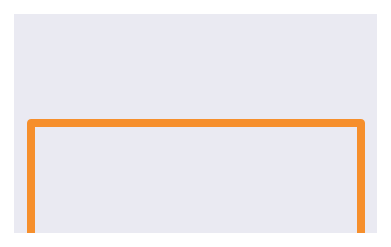

In [156]:
fig, ax = plt.subplots(figsize=(3,2))
xs = np.linspace(-5, 5, 500)
ax.plot(xs, np.ones(xs.size), color='#F68F2C', lw=4)
ax.vlines([-5, 5], [0,0], [1, 1], color='#F68F2C', lw=4)
ax.grid(False)
ax.set_alpha(0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim(0, 2)
fig.tight_layout()
fig.savefig('/Users/mat/Desktop/uniform.png', transparent=True, dpi=300)

In [261]:
import sampyl as smp
from sampyl import np

icov = np.linalg.inv(np.array([[1., .8], [.8, 1.]]))
def logp(x, y):
    d = np.array([x, y])
    return -.5 * np.dot(np.dot(d, icov), d)

start = {'x': 3.5, 'y': 3.5}
nuts = smp.Metropolis(logp, start)
chain = nuts.sample(2000, thin=2)

Progress: [##############################] 2000 of 2000 samples


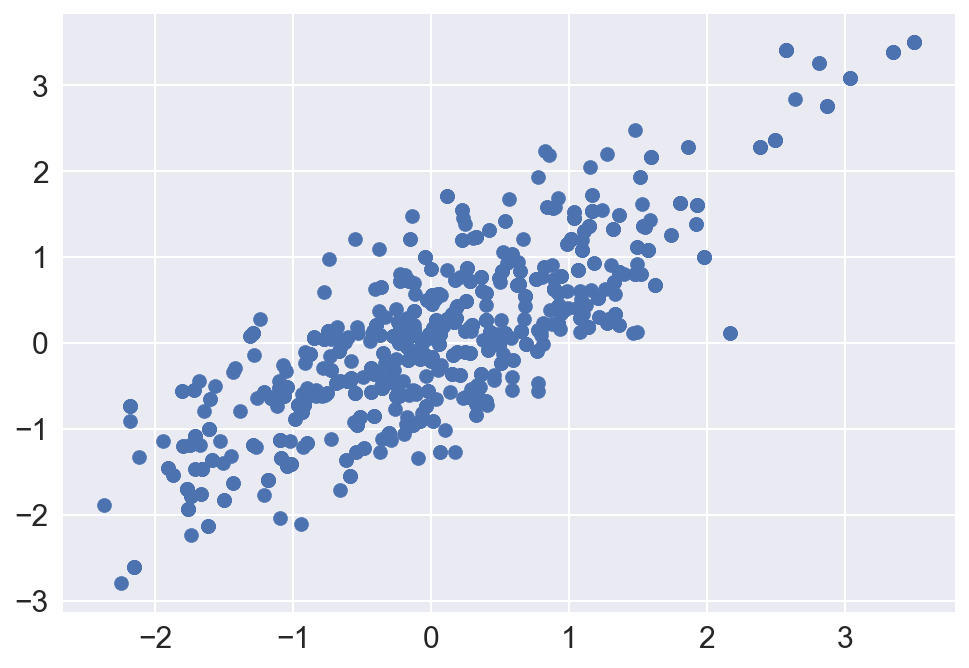

In [223]:
plt.scatter(chain.x, chain.y)

In [164]:
mv = stats.multivariate_normal(cov=np.array([[1., .8], [.8, 1.]]))

In [175]:
X.flatten()

array([-3.        , -2.89830508, -2.79661017, ...,  2.79661017,
        2.89830508,  3.        ])

In [218]:
N = 1000
X = np.linspace(-4, 4, N)
Y = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))

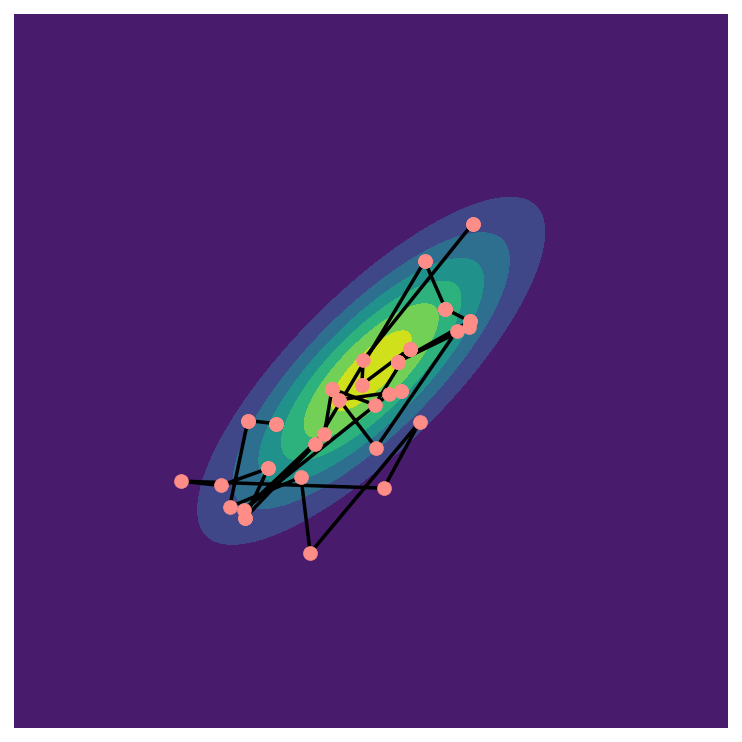

In [263]:
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X, Y, mv.pdf(pos), cmap=plt.cm.viridis)
ax.scatter(chain.x[-50:], chain.y[-50:], color='#FF8D87', zorder=2)
ax.plot(chain.x[-50:], chain.y[-50:], color='k', zorder=1)
ax.set_xticklabels('')
ax.set_yticklabels('')
fig.tight_layout(pad=0.1)
fig.savefig('/Users/mat/Desktop/mcmc_example_converged.png', dpi=300)

In [77]:
housing = pd.read_csv('train.csv', index_col=0)
housing.head()

x = housing.iloc[:,:-1]
cache = {'means': x.mean(), 'std': x.std()}
x = (x - x.mean())/x.std()
X = x.values
housing.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
11,0.22489,12.5,7.87,0,0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15.0
12,0.11747,12.5,7.87,0,0.524,6.009,82.9,6.2267,5,311,15.2,396.90,13.27,18.9
13,0.09378,12.5,7.87,0,0.524,5.889,39.0,5.4509,5,311,15.2,390.50,15.71,21.7
14,0.62976,0.0,8.14,0,0.538,5.949,61.8,4.7075,4,307,21.0,396.90,8.26,20.4


In [78]:
y = housing.iloc[:,-1]
Y = y.values
y.head()

ID
1    24.0
2    21.6
4    33.4
5    36.2
7    22.9
Name: medv, dtype: float64

In [79]:
y.max()

50.0

In [60]:
# Here, β is an array of coefficients
def logp(β, α, ϵ):
    
    model = smp.Model()
    
    # Estimate from our data and coefficients
    estimate = np.dot(X, β) + α
    
    # Add log-likelihood
    model.add(smp.normal(Y, mu=estimate, sig=ϵ))
    
    # Add prior for estimate error
    model.add(smp.half_cauchy(ϵ, 5))
    
    # Uniform priors on coefficients
    model.add(smp.uniform(β, lower=-50, upper=50),
              smp.uniform(α, lower=-50, upper=50))
    
    return model()

In [213]:
start = {'β': np.zeros(X.shape[1]), "α": 0., "ϵ": 1.}
sampler = smp.Slice(logp, start)
chain = sampler(10000, burn=1000, thin=3)

Progress: [##############################] 10000 of 10000 samples


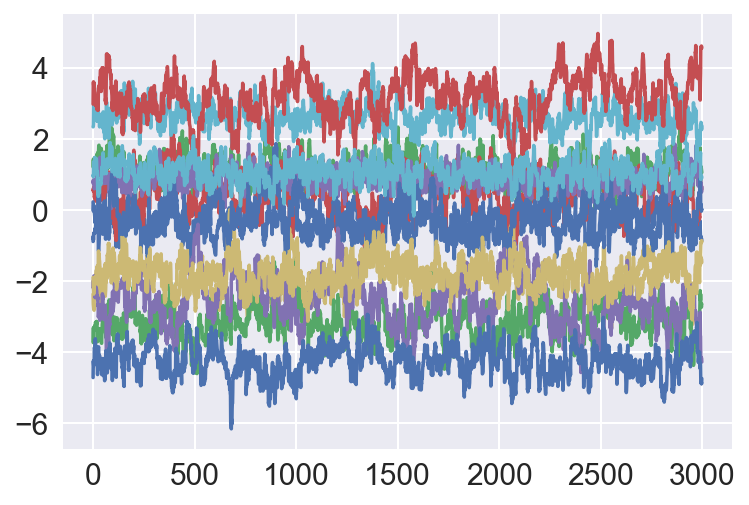

In [112]:
plt.plot(chain.β);

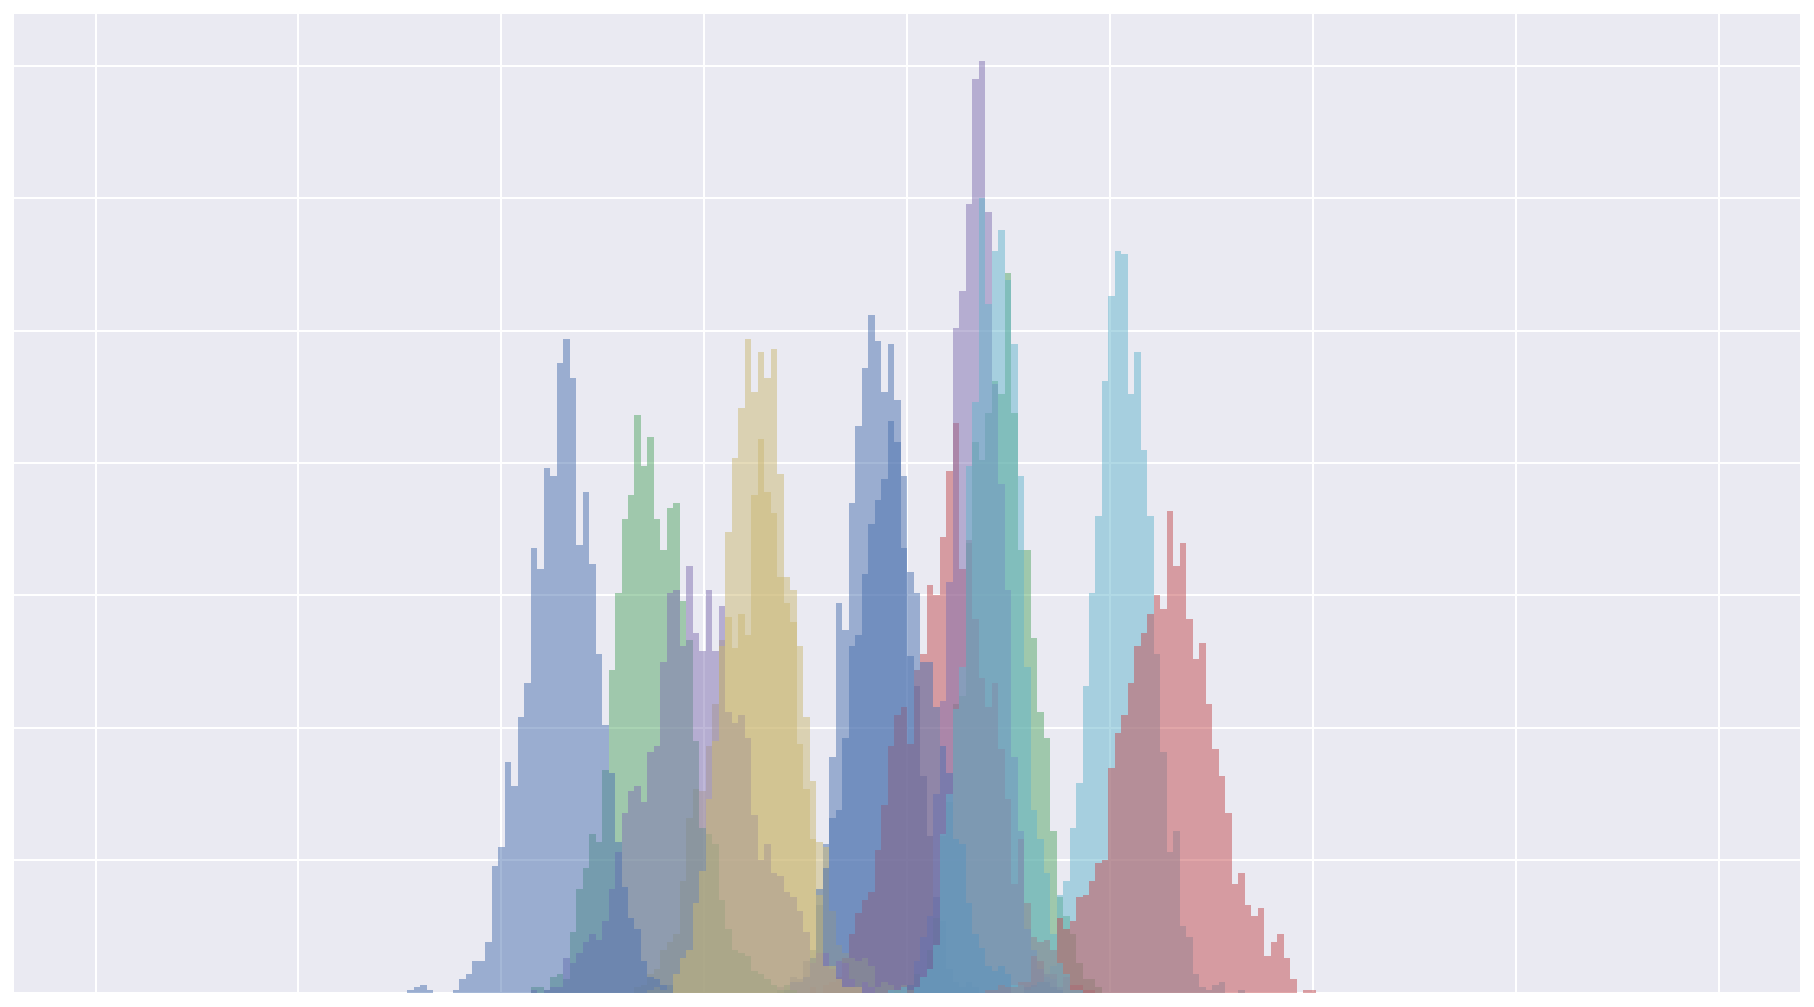

In [113]:
fig, ax = plt.subplots(figsize=(16,9))
for each in chain.β.T:
    ax.hist(each, range=(-10, 10), bins=250, alpha=0.5)
ax.set_xticklabels('')
ax.set_yticklabels('');

In [180]:
def coeff_plot(coeff, ax=None, alpha=1):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,5))
    CRs = np.percentile(coeff, [2.5, 97.5], axis=0)
    means = coeff.mean(axis=0)
    ax.errorbar(means, np.arange(len(means)), xerr=np.abs(means - CRs), fmt='o', alpha=alpha)
    
    ax.grid(True, axis='x', color="#CCCCCC")
    ax.tick_params(axis='both', length=0)
    for each in ['top', 'right', 'left', 'bottom']:
        ax.spines[each].set_visible(False)
    
    return ax

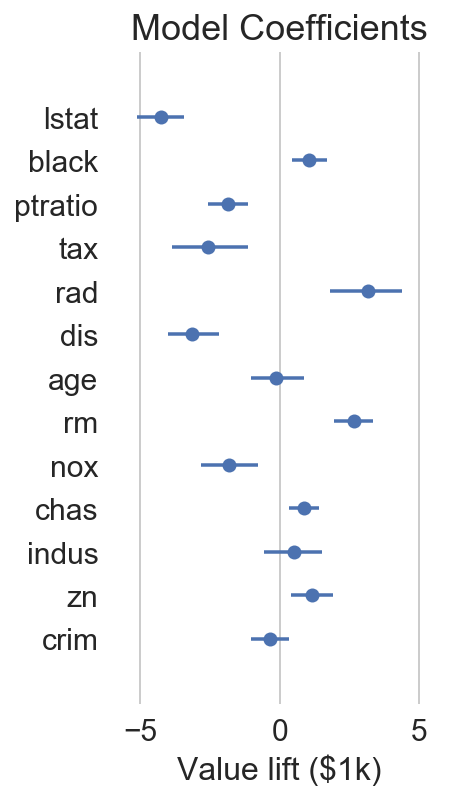

In [115]:
fig, ax = plt.subplots(figsize=(3,6))
ax.grid(False)
ax.set_facecolor('w')
ax = coeff_plot(chain.β, ax=ax)
ax.set_xlim(-6, 6)
ax.set_ylim(-1.5, 13.5)
ax.set_yticks(np.arange(len(x.columns)))
ax.set_yticklabels(x.columns)
ax.set_title("Model Coefficients")
ax.set_xlabel('Value lift ($1k)');

In [100]:
# Now make predictions...


In [101]:
from scipy import stats

In [151]:
# Get one random 
predict_data = np.random.randn(x.shape[1])

idx = np.random.choice(np.arange(chain.size))
post_sample = chain[idx]
estimate = np.dot(predict_data, post_sample.β) + post_sample.α

single_predict = stats.norm(loc=estimate, scale=post_sample.σ).rvs()

# Now make posterior predictive distribution to get uncertainty
estimate = np.dot(predict_data, chain.β.T) + chain.α
post_predict = stats.norm(loc=estimate, scale=chain.σ).rvs()

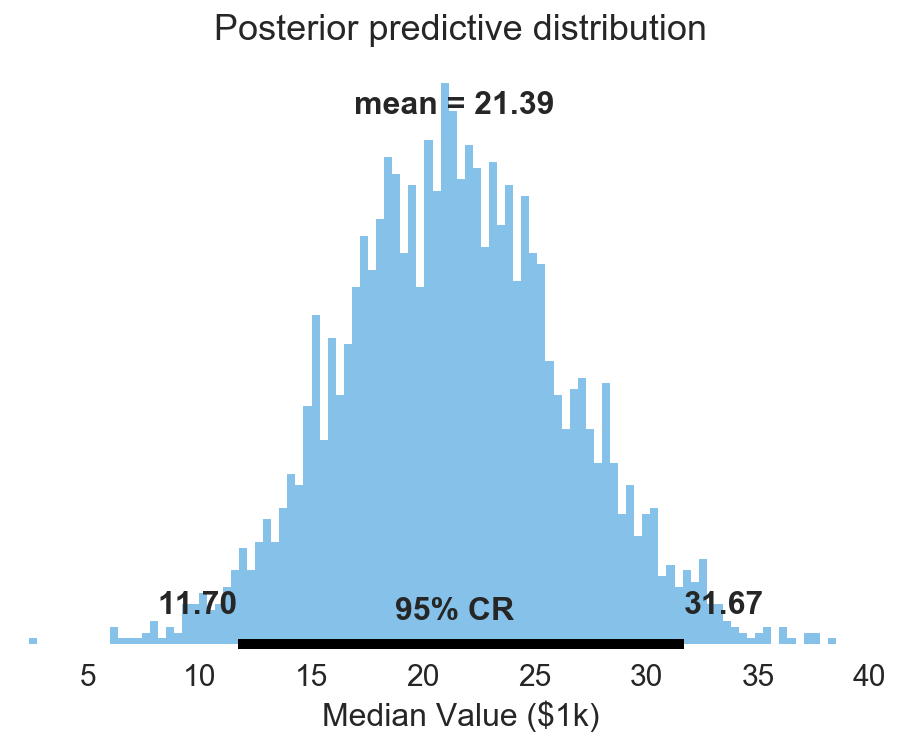

In [175]:
fig, ax = plt.subplots()

hist, _, _ = ax.hist(post_predict, bins=100, density=True, color='#85C1E9')
ax.set_title('Posterior predictive distribution')
ax.set_xlabel('Median Value ($1k)');
mean = np.mean(post_predict)
CR = np.percentile(post_predict, (2.5, 97.5))
ax.hlines(0, CR[0], CR[1], linewidth=5)
ax.set_ylim(-0.001, max(hist)+0.005)
ax.set_xlim(left=CR[0]-10, right=CR[1]+10)
ax.text(CR[0], 0.005, f"{CR[0]:.2f}", weight='bold', ha='right')
ax.text(CR[1], 0.005, f"{CR[1]:.2f}", weight='bold')
ax.text(mean, ax.get_ylim()[1] - 0.01, f"mean = {mean:.2f}", weight='bold', ha='center')
ax.text(mean, ax.get_ylim()[0] + 0.005, f"95% CR", weight='bold', ha='center')
ax.set_yticklabels('')
ax.set_facecolor('w')

In [210]:
# Here, β is an array of coefficients
def logp(β, α, ϵ):
    
    model = smp.Model()
    
    # Add prior for estimate error
    model.add(smp.half_cauchy(ϵ, 5))
    
    # Uniform priors on coefficients
    model.add(smp.normal(β, sig=1),
              smp.normal(α, sig=1))
    
    # Estimate from our data and coefficients
    estimate = np.dot(X, β) + α
    
    # Add log-likelihood
    model.add(smp.normal(Y, mu=estimate, sig=ϵ))
    
    return model()

In [212]:
start = {'β': np.zeros(x.shape[1]), "α": 0., "ϵ": 1.}
sampler = smp.Slice(logp, start)
chain_norm = sampler(10000, burn=1000, thin=3)

Progress: [##############################] 10000 of 10000 samples


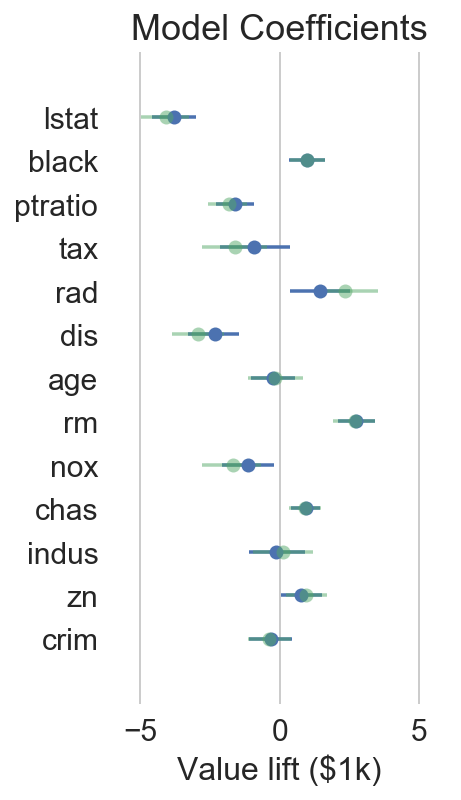

In [200]:
fig, ax = plt.subplots(figsize=(3,6))
ax.grid(False)
ax.set_facecolor('w')
ax = coeff_plot(chain_norm.β, ax=ax)
ax = coeff_plot(chain.β, ax=ax, alpha=0.5)
ax.set_xlim(-6, 6)
ax.set_ylim(-1.5, 13.5)
ax.set_yticks(np.arange(len(x.columns)))
ax.set_yticklabels(x.columns)
ax.set_title("Model Coefficients")
ax.set_xlabel('Value lift ($1k)');

In [201]:
# Get one random 
predict_data = np.random.randn(x.shape[1])

# Now make posterior predictive distribution to get uncertainty
estimate = np.dot(predict_data, chain_norm.β.T) + chain_norm.α
post_predict_norm = stats.norm(loc=estimate, scale=chain_norm.σ).rvs()

# Now make posterior predictive distribution to get uncertainty
estimate = np.dot(predict_data, chain.β.T) + chain.α
post_predict = stats.norm(loc=estimate, scale=chain.σ).rvs()

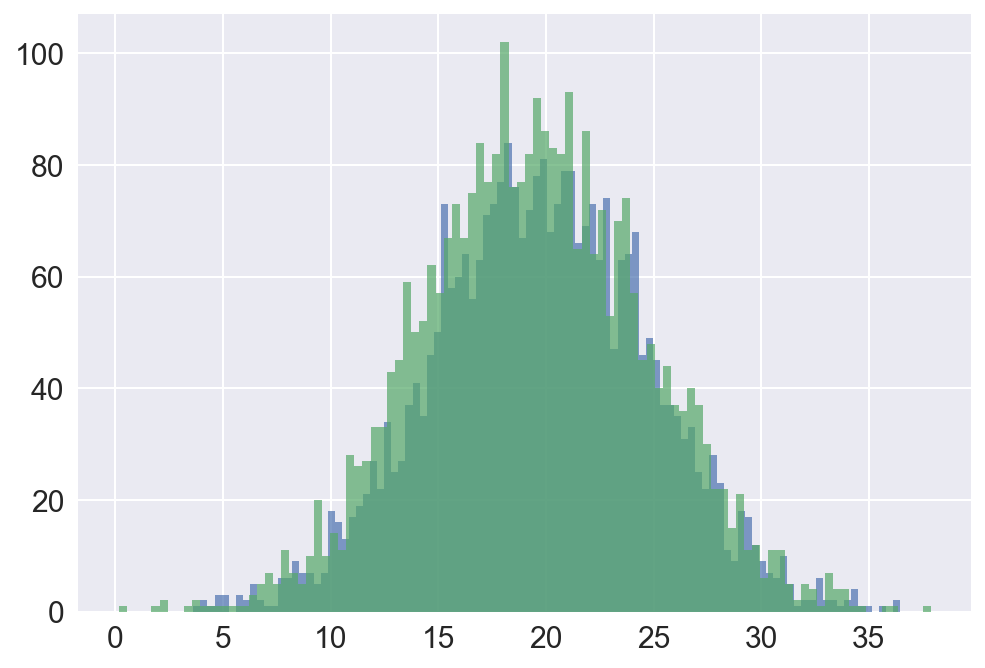

In [209]:
plt.hist(post_predict, alpha=0.7, bins=100)
plt.hist(post_predict_norm, alpha=0.7, bins=100);

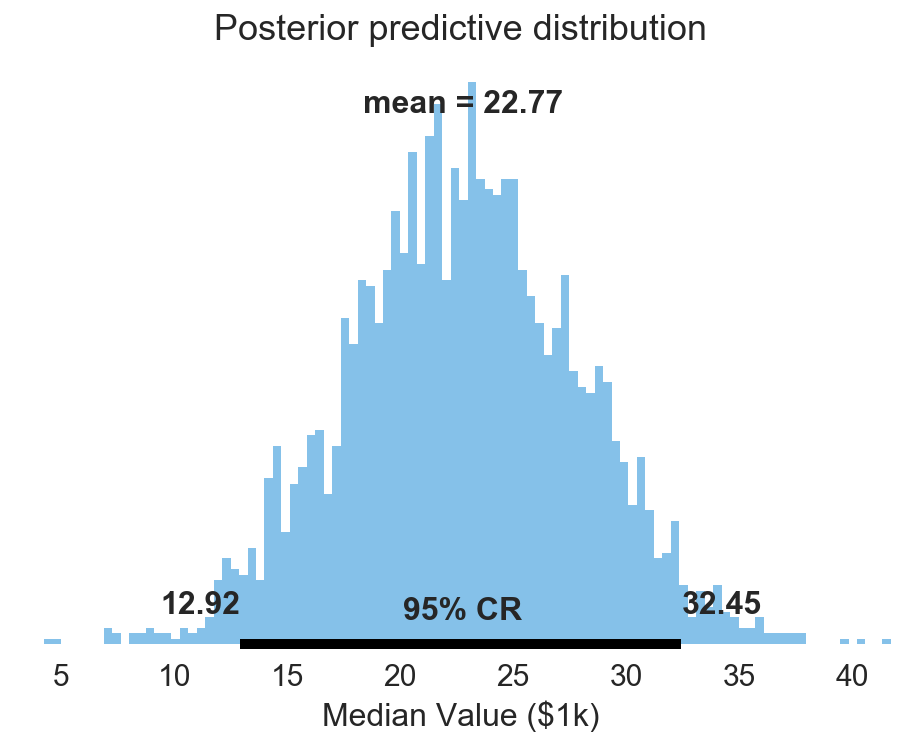

In [197]:
fig, ax = plt.subplots()

post = post_predict

hist, _, _ = ax.hist(post, bins=100, density=True, color='#85C1E9')
ax.set_title('Posterior predictive distribution')
ax.set_xlabel('Median Value ($1k)');
mean = np.mean(post)
CR = np.percentile(post, (2.5, 97.5))
ax.hlines(0, CR[0], CR[1], linewidth=5)
ax.set_ylim(-0.001, max(hist)+0.005)
ax.set_xlim(left=CR[0]-10, right=CR[1]+10)
ax.text(CR[0], 0.005, f"{CR[0]:.2f}", weight='bold', ha='right')
ax.text(CR[1], 0.005, f"{CR[1]:.2f}", weight='bold')
ax.text(mean, ax.get_ylim()[1] - 0.01, f"mean = {mean:.2f}", weight='bold', ha='center')
ax.text(mean, ax.get_ylim()[0] + 0.005, f"95% CR", weight='bold', ha='center')
ax.set_yticklabels('')
ax.set_facecolor('w')

In [132]:
challenger

,Temperature,Damage Incident
Date,,
04/12/1981,66,0
11/12/1981,70,1
3/22/82,69,0
01/11/1982,68,0
04/04/1983,67,0
6/18/83,72,0
8/30/83,73,0
11/28/83,70,0
02/03/1984,57,1


In [3]:
challenger = pd.read_csv('challenger_data.csv', index_col=0)
challenger = challenger.dropna()
temp = challenger['Temperature'][:-1].values
damage = challenger['Damage Incident'][:-1].values.astype(np.int_)

Text(0.5,1,'Defect of space shuttle O-rings vs Temperature')

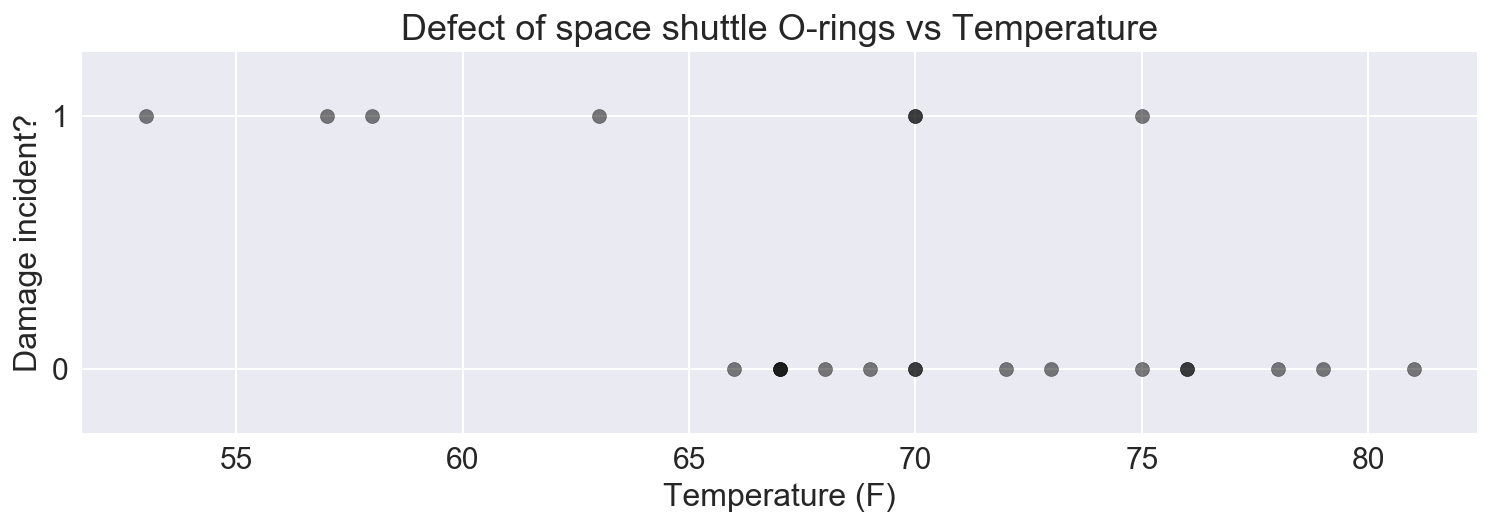

In [63]:
fig, ax = plt.subplots(figsize = (12.5, 3.5))
plt.scatter(temp, damage, color='k', alpha=0.5)
plt.xlabel('Temperature (F)')
plt.yticks((0, 1), ('0', '1'))
plt.ylabel('Damage incident?')
plt.ylim(-0.25, 1.25)
plt.title('Defect of space shuttle O-rings vs Temperature')

In [83]:
def logistic(x):
    return 1/(1 + np.exp(x))

def logp(β, α):
    
    model = smp.Model()
    
    # Uniform priors on coefficients
    model.add(smp.normal(α, sig=1000),
              smp.normal(β, sig=1000))
    
    # Add log-likelihood
    model.add(smp.bernoulli(damage, logistic(temp*β + α)))
    
    return model()

In [50]:
start = {'β': 0., "α": 0.}
sampler = smp.Slice(logp, start)
chain = sampler(220000, burn=20000, thin=3)

Progress: [##############################] 220000 of 220000 samples


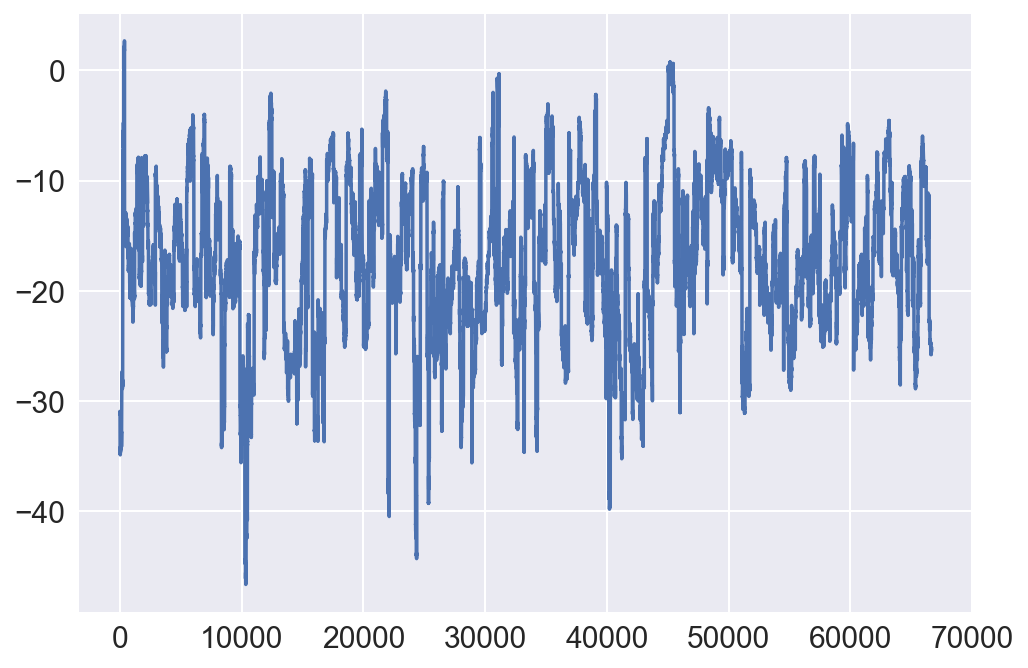

In [80]:
plt.plot(chain.α)

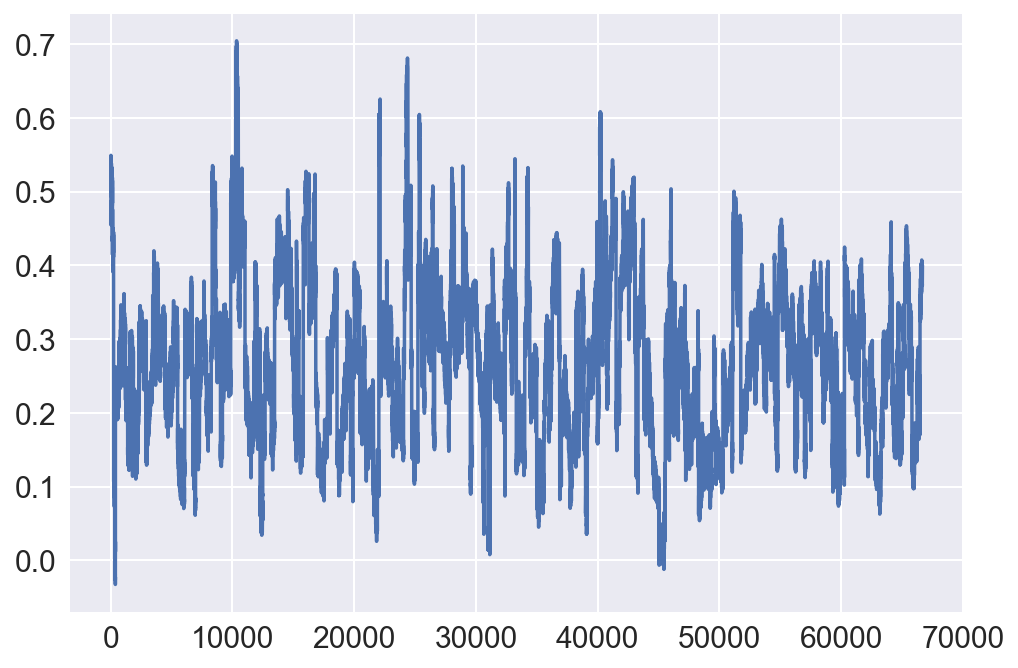

In [81]:
plt.plot(chain.β)

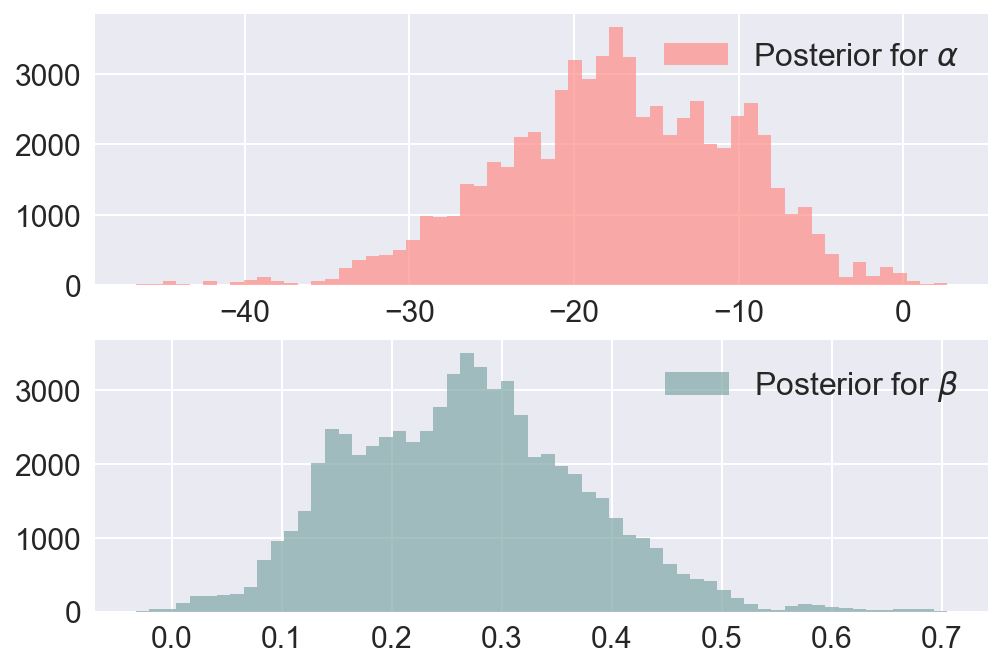

In [82]:
fig, axes = plt.subplots(nrows=2)
axes[0].hist(chain.α, bins=60, label=r'Posterior for $\alpha$', color='#FF8D87', alpha=0.7)
axes[1].hist(chain.β, bins=60, label=r'Posterior for $\beta$', color='#7FA8A7', alpha=0.7)
for ax in axes:
    ax.legend()

A lot of the following code was borrowed from [Probabilistic Programming for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb)

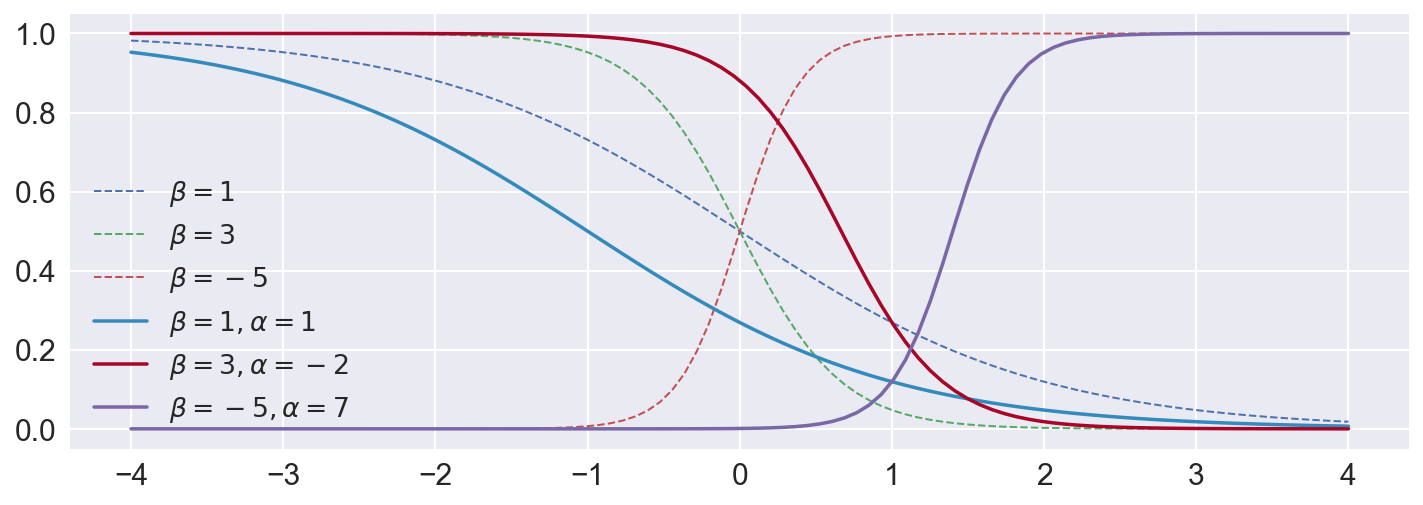

In [71]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
ax.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
ax.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

ax.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
ax.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
ax.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

ax.legend(loc="lower left", fontsize='small');

In [115]:
ts = np.linspace(temp.min() - 5, temp.max()+5, 50)[:, None]
p_t = logistic(ts*chain.β + chain.α).T

mean_p_t = p_t.mean(axis=0)

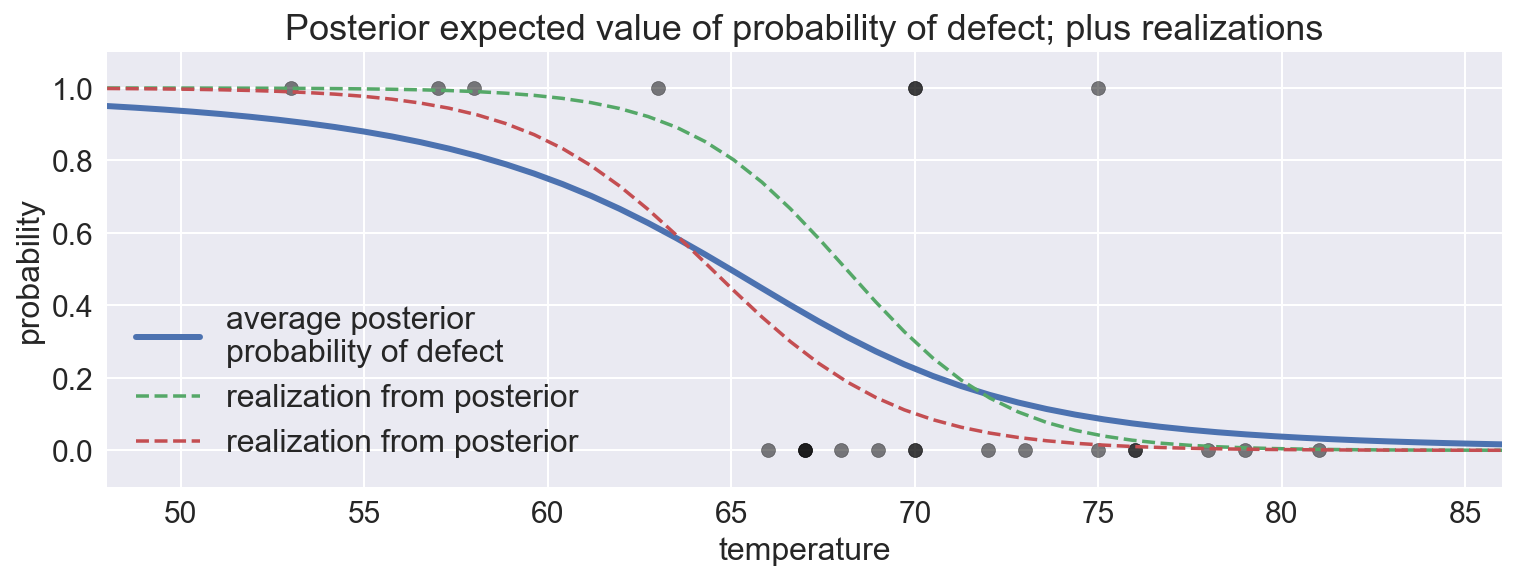

In [116]:
fig, ax = plt.subplots(figsize=(12.5, 4))

ax.plot(ts, mean_p_t, lw=3, label="average posterior \nprobability of defect")
ax.plot(ts, p_t[0, :], ls="--", label="realization from posterior")
ax.plot(ts, p_t[-2, :], ls="--", label="realization from posterior")
ax.scatter(temp, damage, color="k", alpha=0.5)
ax.set_title("Posterior expected value of probability of defect; plus realizations")
ax.legend(loc="lower left")
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(t.min(), t.max())
ax.set_ylabel("probability")
ax.set_xlabel("temperature");

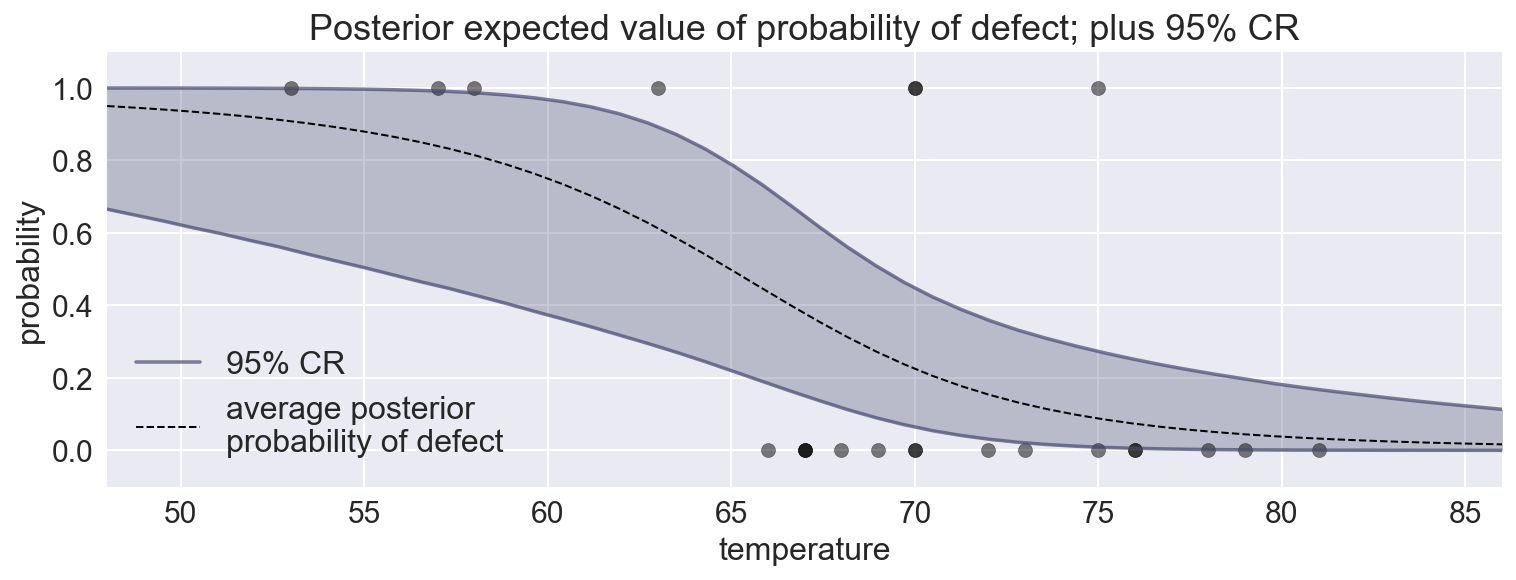

In [131]:
fig, ax = plt.subplots(figsize=(12.5, 4))

qs = np.percentile(p_t, (2.5, 97.5), axis=0)

ax.fill_between(ts[:, 0], qs[0], qs[1], color='#484B70', alpha=0.3)

ax.plot(ts[:, 0], qs[0], label="95% CR", color='#484B70', alpha=0.7)
ax.plot(ts[:, 0], qs[1], color='#484B70', alpha=0.7)

ax.plot(ts, mean_p_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")
ax.scatter(temp, damage, color="k", alpha=0.5)
ax.set_title("Posterior expected value of probability of defect; plus 95% CR")
ax.legend(loc="lower left")
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(t.min(), t.max())
ax.set_ylabel("probability")
ax.set_xlabel("temperature");

In [135]:
from scipy import stats

In [141]:
t_challenger = 31

post_predict = logistic(t_challenger*chain.β + chain.α)

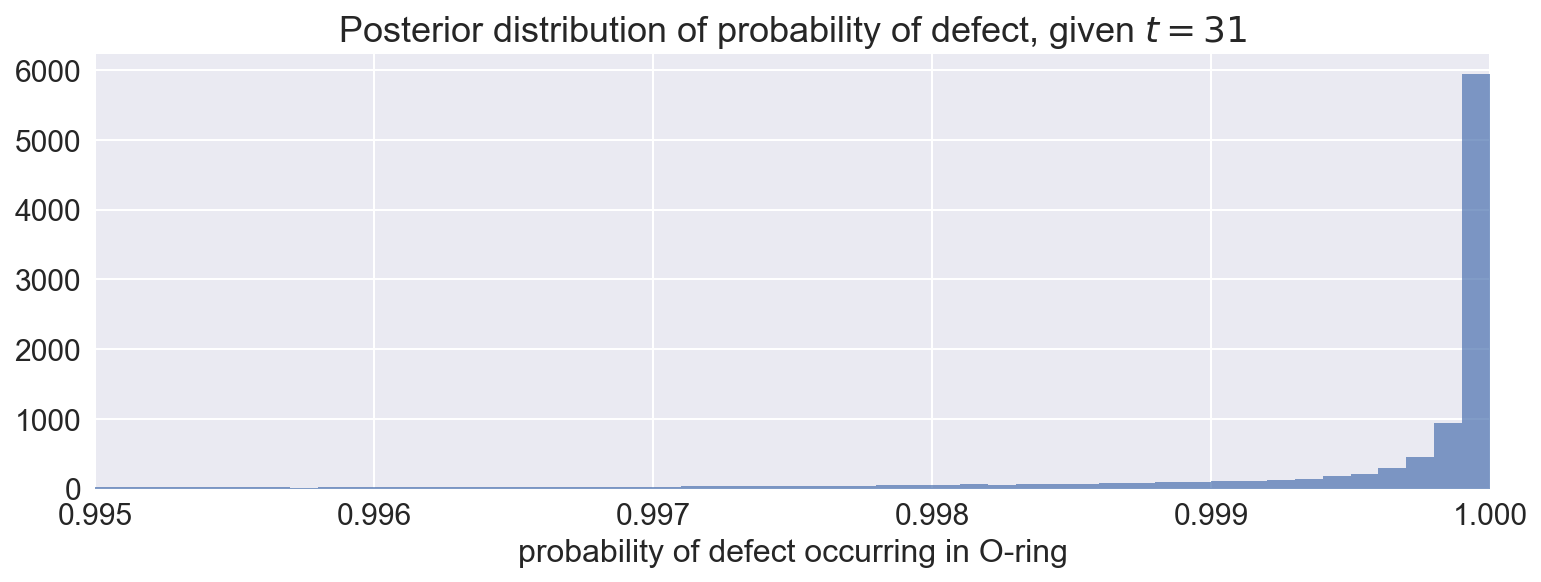

In [151]:
fig, ax = plt.subplots(figsize=(12.5, 4))
ax.hist(post_predict, range=(0.995, 1), bins=50, density=True, alpha=0.7)
ax.set_xlim(0.995, 1)
ax.set_title("Posterior distribution of probability of defect, given $t = 31$")
ax.set_xlabel("probability of defect occurring in O-ring");